<a href="https://colab.research.google.com/github/insaiyancvk/Mad-Artist/blob/main/fast_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/rrmina/fast-neural-style-pytorch

Cloning into 'fast-neural-style-pytorch'...
remote: Enumerating objects: 288, done.
remote: Total 288 (delta 0), reused 0 (delta 0), pack-reused 288
Receiving objects: 100% (288/288), 260.96 MiB | 33.01 MiB/s, done.
Resolving deltas: 100% (136/136), done.
Checking out files: 100% (45/45), done.


In [ ]:
%matplotlib inline

# install pillow
# !pip install Pillow -U

# download and unzip dataset o train
!wget http://images.cocodataset.org/zips/train2014.zip
!mkdir train
%cd /content/train
!unzip -qq /content/train2014.zip
%cd ..
# download helper code
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/transformer.py
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/utils.py
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/vgg.py

# download style image  
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/images/mosaic.jpg

In [2]:
#download model
!wget https://download.pytorch.org/models/vgg16-397923af.pth
!mv vgg16-397923af.pth vgg16.pth
!rm train2014.zip

--2022-10-23 12:58:53--  https://download.pytorch.org/models/vgg16-397923af.pth
Resolving download.pytorch.org (download.pytorch.org)... 13.224.250.5, 13.224.250.24, 13.224.250.7, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.250.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553433881 (528M) [binary/octet-stream]
Saving to: ‘vgg16-397923af.pth’

vgg16-397923af.pth  100%[===================>] 527.79M   252MB/s    in 2.1s    

2022-10-23 12:58:56 (252 MB/s) - ‘vgg16-397923af.pth’ saved [553433881/553433881]



In [3]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import random
import numpy as np
import time
import vgg
import transformer
import utils

In [19]:
 # GLOBAL SETTINGS
TRAIN_IMAGE_SIZE = 512
DATASET_PATH = "/content/train"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "/content/hokusai style.jpg"
BATCH_SIZE = 4
CONTENT_WEIGHT = 17
STYLE_WEIGHT = 50
TV_WEIGHT = 1e-6
ADAM_LR = 0.001
SAVE_MODEL_PATH = "/content/models/"
SAVE_IMAGE_PATH = "/content/images/"
SAVE_MODEL_EVERY = 200 # 800 Images with batch size 4
SEED = 35

In [3]:
if not os.path.exists(SAVE_MODEL_PATH):
  !mkdir $SAVE_MODEL_PATH
if not os.path.exists(SAVE_IMAGE_PATH):
  !mkdir $SAVE_IMAGE_PATH

In [4]:
# Seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
# Device
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Dataset and Dataloader
transform = transforms.Compose([
    transforms.Resize(TRAIN_IMAGE_SIZE),
    transforms.CenterCrop(TRAIN_IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])
train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
# Load networks
TransformerNetwork = transformer.TransformerNetwork().to(device)
VGG = vgg.VGG16('/content/vgg16.pth').to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [32]:
# Get Style Features
imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
imagenet_mean = torch.tensor([103.939, 116.779, 123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
style_image = utils.load_image(STYLE_IMAGE_PATH)
style_tensor = utils.itot(style_image).to(device)
style_tensor = style_tensor.add(imagenet_neg_mean)
B, C, H, W = style_tensor.shape
style_features = VGG(style_tensor.expand([BATCH_SIZE, C, H, W]))
style_gram = {}
for key, value in style_features.items():
    style_gram[key] = utils.gram(value)

In [33]:
# Optimizer settings
optimizer = optim.Adam(TransformerNetwork.parameters(), lr=ADAM_LR)

In [34]:
# Loss trackers
content_loss_history = []
style_loss_history = []
total_loss_history = []
batch_content_loss_sum = 0
batch_style_loss_sum = 0
batch_total_loss_sum = 0

========Epoch 1/2========
========Iteration 1/20696========
	Content Loss:	661918.38
	Style Loss:	14034584.00
	Total Loss:	14696502.00
Time elapsed:	1.0837481021881104 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_0.pth


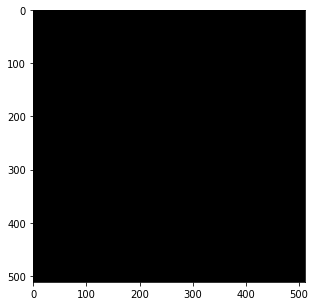

Saved sample tranformed image at /content/images/sample0_0.png
========Iteration 201/20696========
	Content Loss:	290078.38
	Style Loss:	2161635.50
	Total Loss:	2451714.43
Time elapsed:	196.24770259857178 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_200.pth


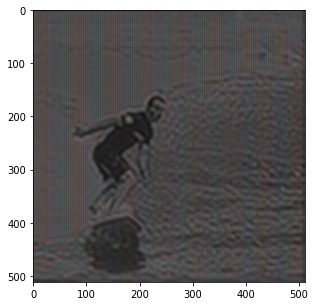

Saved sample tranformed image at /content/images/sample0_200.png
========Iteration 401/20696========
	Content Loss:	271808.00
	Style Loss:	1394404.12
	Total Loss:	1666212.39
Time elapsed:	401.0663285255432 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_400.pth


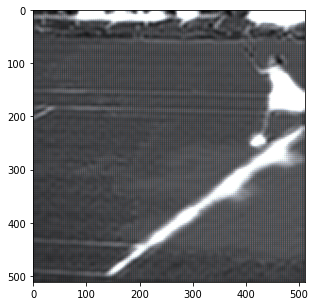

Saved sample tranformed image at /content/images/sample0_400.png
========Iteration 601/20696========
	Content Loss:	275671.88
	Style Loss:	990955.62
	Total Loss:	1266627.75
Time elapsed:	606.3350079059601 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_600.pth


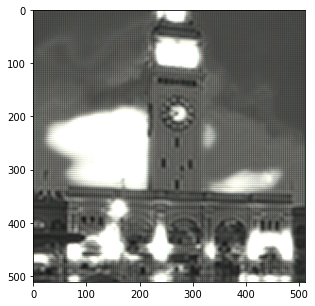

Saved sample tranformed image at /content/images/sample0_600.png
========Iteration 801/20696========
	Content Loss:	275008.50
	Style Loss:	777349.81
	Total Loss:	1052358.28
Time elapsed:	812.1453275680542 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_800.pth


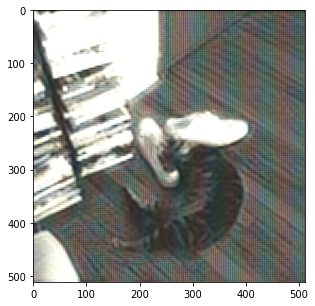

Saved sample tranformed image at /content/images/sample0_800.png
========Iteration 1001/20696========
	Content Loss:	271994.62
	Style Loss:	645550.06
	Total Loss:	917544.91
Time elapsed:	1018.1359140872955 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_1000.pth


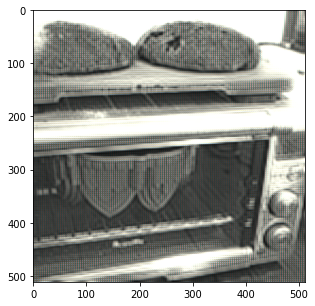

Saved sample tranformed image at /content/images/sample0_1000.png
========Iteration 1201/20696========
	Content Loss:	268265.94
	Style Loss:	555880.19
	Total Loss:	824146.70
Time elapsed:	1224.0188393592834 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_1200.pth


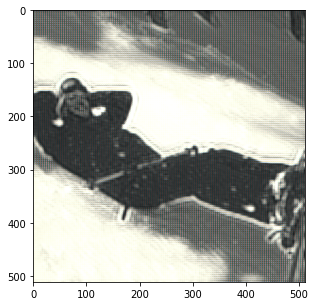

Saved sample tranformed image at /content/images/sample0_1200.png
========Iteration 1401/20696========
	Content Loss:	266578.53
	Style Loss:	490771.72
	Total Loss:	757350.65
Time elapsed:	1429.8663456439972 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_1400.pth


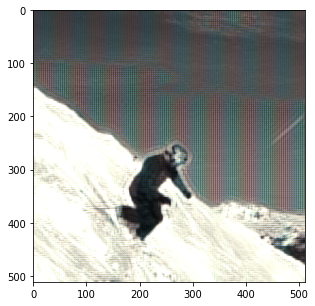

Saved sample tranformed image at /content/images/sample0_1400.png
========Iteration 1601/20696========
	Content Loss:	263913.38
	Style Loss:	441419.28
	Total Loss:	705332.91
Time elapsed:	1636.091097354889 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_1600.pth


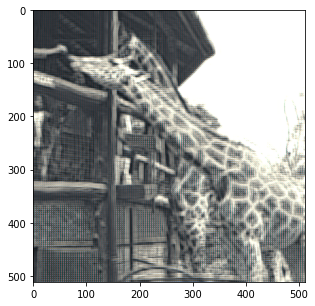

Saved sample tranformed image at /content/images/sample0_1600.png
========Iteration 1801/20696========
	Content Loss:	261115.44
	Style Loss:	402464.00
	Total Loss:	663579.40
Time elapsed:	1842.4254291057587 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_1800.pth


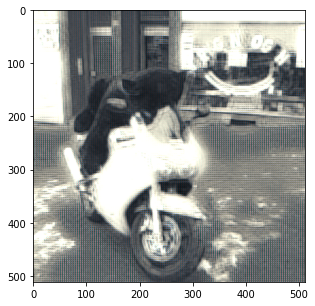

Saved sample tranformed image at /content/images/sample0_1800.png
========Iteration 2001/20696========
	Content Loss:	258641.83
	Style Loss:	371101.12
	Total Loss:	629742.78
Time elapsed:	2048.4563097953796 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_2000.pth


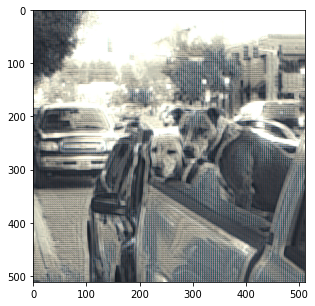

Saved sample tranformed image at /content/images/sample0_2000.png
========Iteration 2201/20696========
	Content Loss:	256977.09
	Style Loss:	345127.91
	Total Loss:	602104.91
Time elapsed:	2255.024445295334 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_2200.pth


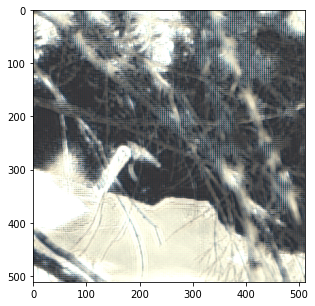

Saved sample tranformed image at /content/images/sample0_2200.png
========Iteration 2401/20696========
	Content Loss:	254874.08
	Style Loss:	323292.88
	Total Loss:	578167.02
Time elapsed:	2461.345541000366 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_2400.pth


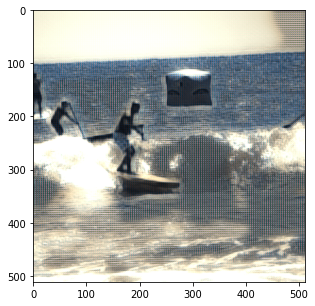

Saved sample tranformed image at /content/images/sample0_2400.png
========Iteration 2601/20696========
	Content Loss:	252350.16
	Style Loss:	304501.06
	Total Loss:	556851.38
Time elapsed:	2667.7298033237457 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_2600.pth


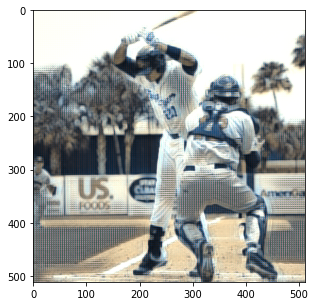

Saved sample tranformed image at /content/images/sample0_2600.png
========Iteration 2801/20696========
	Content Loss:	249906.97
	Style Loss:	288194.44
	Total Loss:	538101.58
Time elapsed:	2873.890932559967 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_2800.pth


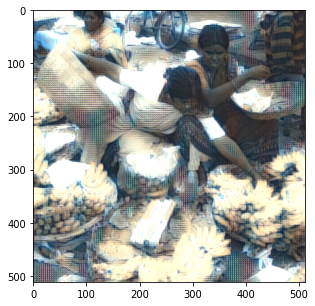

Saved sample tranformed image at /content/images/sample0_2800.png
========Iteration 3001/20696========
	Content Loss:	247380.77
	Style Loss:	273888.66
	Total Loss:	521269.55
Time elapsed:	3080.5125958919525 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_3000.pth


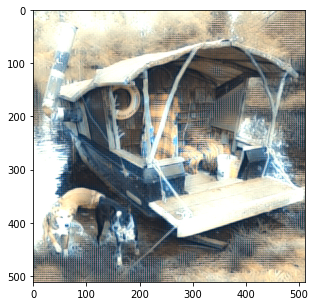

Saved sample tranformed image at /content/images/sample0_3000.png
========Iteration 3201/20696========
	Content Loss:	244910.84
	Style Loss:	261119.89
	Total Loss:	506030.67
Time elapsed:	3286.8253219127655 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_3200.pth


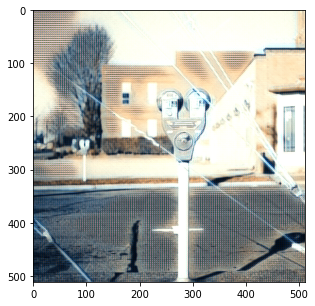

Saved sample tranformed image at /content/images/sample0_3200.png
========Iteration 3401/20696========
	Content Loss:	242364.25
	Style Loss:	249759.69
	Total Loss:	492123.96
Time elapsed:	3493.209187269211 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_3400.pth


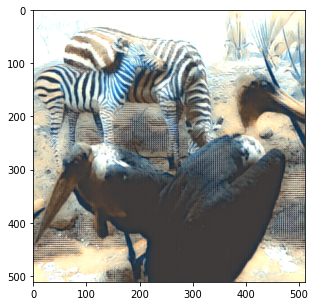

Saved sample tranformed image at /content/images/sample0_3400.png
========Iteration 3601/20696========
	Content Loss:	240400.58
	Style Loss:	239636.17
	Total Loss:	480036.47
Time elapsed:	3699.2604496479034 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_3600.pth


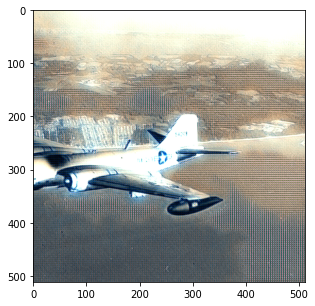

Saved sample tranformed image at /content/images/sample0_3600.png
========Iteration 3801/20696========
	Content Loss:	238006.31
	Style Loss:	230435.42
	Total Loss:	468441.48
Time elapsed:	3905.8159375190735 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_3800.pth


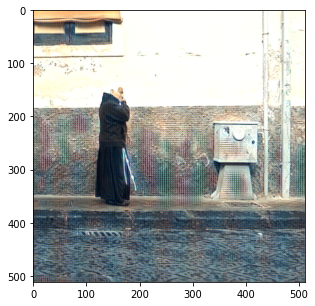

Saved sample tranformed image at /content/images/sample0_3800.png
========Iteration 4001/20696========
	Content Loss:	236088.64
	Style Loss:	222143.25
	Total Loss:	458231.66
Time elapsed:	4112.1550924777985 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_4000.pth


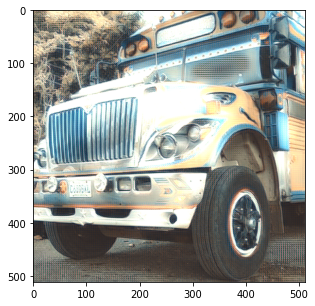

Saved sample tranformed image at /content/images/sample0_4000.png
========Iteration 4201/20696========
	Content Loss:	233973.22
	Style Loss:	214553.75
	Total Loss:	448526.90
Time elapsed:	4318.606040477753 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_4200.pth


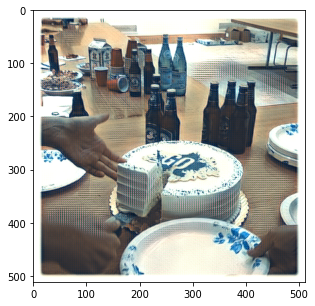

Saved sample tranformed image at /content/images/sample0_4200.png
========Iteration 4401/20696========
	Content Loss:	231890.53
	Style Loss:	207630.97
	Total Loss:	439521.25
Time elapsed:	4525.29622220993 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_4400.pth


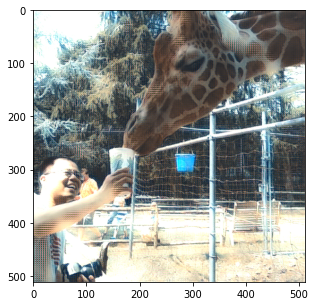

Saved sample tranformed image at /content/images/sample0_4400.png
========Iteration 4601/20696========
	Content Loss:	229739.03
	Style Loss:	201255.70
	Total Loss:	430994.36
Time elapsed:	4731.963399171829 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_4600.pth


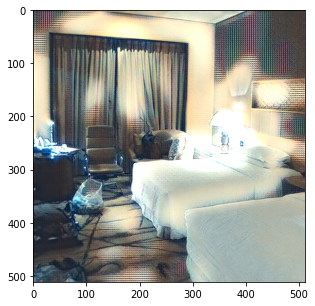

Saved sample tranformed image at /content/images/sample0_4600.png
========Iteration 4801/20696========
	Content Loss:	227512.77
	Style Loss:	195362.39
	Total Loss:	422874.80
Time elapsed:	4938.2763204574585 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_4800.pth


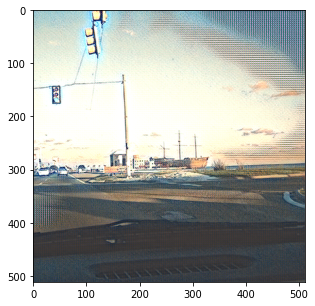

Saved sample tranformed image at /content/images/sample0_4800.png
========Iteration 5001/20696========
	Content Loss:	225642.58
	Style Loss:	189956.80
	Total Loss:	415599.12
Time elapsed:	5144.763402223587 seconds
Saved TransformerNetwork checkpoint file at /content/models/checkpoint_5000.pth


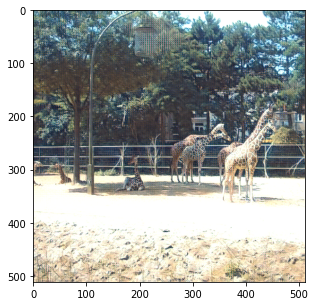

Saved sample tranformed image at /content/images/sample0_5000.png


In [ ]:
# Optimization/Training Loop
batch_count = 1
start_time = time.time()
for epoch in range (1, NUM_EPOCHS+1):
    print("========Epoch {}/{}========".format(epoch, NUM_EPOCHS+1))
    for batch_id, (content_batch, _) in enumerate(train_loader):
        # Current Batch size in case of odd batches
        curr_batch_size = content_batch.shape[0]
        
        # Zero-out Gradients
        optimizer.zero_grad()

        # Generate images and get features
        content_batch = content_batch[:,[2,1,0]].to(device)
        generated_batch = TransformerNetwork(content_batch)
        content_features = VGG(content_batch.add(imagenet_neg_mean))
        generated_features = VGG(generated_batch.add(imagenet_neg_mean))

        # Content Loss
        MSELoss = nn.MSELoss().to(device)
        content_loss = CONTENT_WEIGHT * MSELoss(content_features['relu2_2'], generated_features['relu2_2'])            
        batch_content_loss_sum += content_loss

        # Style Loss
        style_loss = 0
        for key, value in generated_features.items():
            s_loss = MSELoss(utils.gram(value), style_gram[key][:curr_batch_size])
            style_loss += s_loss
        style_loss *= STYLE_WEIGHT
        batch_style_loss_sum += style_loss

        # Total Loss
        total_loss = content_loss + style_loss
        batch_total_loss_sum += total_loss.item()

        # Backprop and Weight Update
        total_loss.backward()
        optimizer.step()

        # Save Model and Print Losses
        if (((batch_count-1)%SAVE_MODEL_EVERY == 0) or (batch_count==NUM_EPOCHS*len(train_loader))):
            # Print Losses
            print("========Iteration {}/{}========".format(batch_count, NUM_EPOCHS*len(train_loader)))
            print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_count))
            print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_count))
            print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_count))
            print("Time elapsed:\t{} seconds".format(time.time()-start_time))

            # Save Model
            checkpoint_path = SAVE_MODEL_PATH + "checkpoint_" + str(batch_count-1) + ".pth"
            torch.save(TransformerNetwork.state_dict(), checkpoint_path)
            print("Saved TransformerNetwork checkpoint file at {}".format(checkpoint_path))

            # Save sample generated image
            sample_tensor = generated_batch[0].clone().detach().unsqueeze(dim=0)
            sample_image = utils.ttoi(sample_tensor.clone().detach())
            sample_image_path = SAVE_IMAGE_PATH + "sample0_" + str(batch_count-1) + ".png"
            utils.saveimg(sample_image, sample_image_path)
            utils.show(sample_image)
            print("Saved sample tranformed image at {}".format(sample_image_path))

            # Save loss histories
            content_loss_history.append(batch_total_loss_sum/batch_count)
            style_loss_history.append(batch_style_loss_sum/batch_count)
            total_loss_history.append(batch_total_loss_sum/batch_count)

        # Iterate Batch Counter
        batch_count+=1

stop_time = time.time()
# Print loss histories
print("Done Training the Transformer Network!")
print("Training Time: {} seconds".format(stop_time-start_time))
print("========Content Loss========")
print(content_loss_history) 
print("========Style Loss========")
print(style_loss_history) 
print("========Total Loss========")
print(total_loss_history) 

In [ ]:
# Save TransformerNetwork weights
TransformerNetwork.eval()
TransformerNetwork.cpu()
final_path = SAVE_MODEL_PATH + f"{}transformer_weight.pth"
print("Saving TransformerNetwork weights at {}".format(final_path))
torch.save(TransformerNetwork.state_dict(), final_path)
print("Done saving final model")

In [ ]:
!cp $final_path "/content/drive/MyDrive/Style Transfer/fast style transfer"

In [ ]:
!cp "/content/drive/MyDrive/Style Transfer/fast style transfer/transformer_weight.pth" .

In [ ]:
# Device
device = ("cuda" if torch.cuda.is_available() else "cpu")

# Load Transformer Network
net = transformer.TransformerNetwork()
net.load_state_dict(torch.load(STYLE_TRANSFORM_PATH))
net = net.to(device)

with torch.no_grad():
  torch.cuda.empty_cache()
  # print("Stylize Image~ Press Ctrl+C and Enter to close the program")
  content_image_path = "cityscape.jpg"
  content_image = utils.load_image(content_image_path)
  starttime = time.time()
  content_tensor = utils.itot(content_image).to(device)
  generated_tensor = net(content_tensor)
  generated_image = utils.ttoi(generated_tensor.detach())
  if (PRESERVE_COLOR):
      generated_image = utils.transfer_color(content_image, generated_image)
  print("Transfer Time: {}".format(time.time() - starttime))
  utils.show(generated_image)
  utils.saveimg(generated_image, f"{content_image_path.split('.')[0]}-style.jpg")

In [ ]:
!curl -o puppy.jpg https://www.thesprucepets.com/thmb/ROV348T6Uyc1FfD5jsETO8bc1mI=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/GoldenPuppy185743593-56a9c1f23df78cf772aa4a33.jpg

In [ ]:
!curl -o night.jpg https://www.travelanddestinations.com/wp-content/uploads/2016/05/Toronto-skyline-at-night-1.jpg

In [ ]:
!curl -o cityscape.jpg https://iso.500px.com/wp-content/uploads/2014/07/hong-kong-cityscape1.jpg